<a href="https://colab.research.google.com/github/DiGyt/snippets/blob/master/MultivariateSimulations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

BSD 3-Clause License

Copyright (c) 2020, Dirk Gütlin

All rights reserved.



# Multivariate Simulations
---
<br><br><br>

A collection of some of my data generation functions, mainly focussing on simulation of dependent or independent Random Processes or Time Series and the resulting Multivariate Data Structures.

The main goal of these simulations is to generate data of scalable complexity in order to investigate the performance of different types of regression solvers and machine/deep learning algorithms.

In [ ]:
import numpy as np

from scipy import stats
from scipy import integrate

from statsmodels.tsa.arima_process import arma_generate_sample

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## Simulate complex high dimension probability distributions

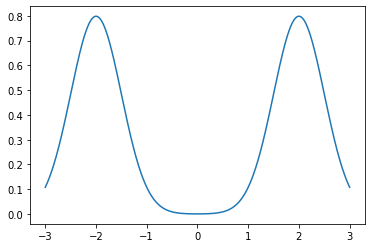

In [ ]:
def gaussian(x, mu=0, sigma=1):
  f_x = 1/(sigma*np.sqrt(2*np.pi)) * np.exp(-(1/2) * ((x - mu) / sigma) ** 2)
  return f_x

def arb_dist(x, mu_0=-2, sigma_0=0.5, mu_1=2, sigma_1=0.5):
  f_x = 1/(sigma_0 * np.sqrt(2*np.pi)) * np.exp(-(1/2) * ((x - mu_0) / sigma_0) ** 2) + 1/(sigma_1 * np.sqrt(2*np.pi)) * np.exp(-(1/2) * ((x - mu_1) / sigma_1) ** 2)
  return f_x

x_range = np.linspace(-3, 3, 2000)
plt.plot(x_range, [arb_dist(i) for i in x_range])

In [ ]:
def normalize_pdf(pdf):

  integral = integrate.quad(pdf, -np.inf, np.inf)[0]

  def norm_pdf(x):
    return pdf(x) / integral

  return norm_pdf


class RandomDist(stats.rv_continuous):

  def __init__(self, custom_pdf):

    if not (0.99 < integrate.quad(custom_pdf, -np.inf, np.inf)[0] < 1.01):
      raise Exception("PDF must have an integral == 1.")

    self._custom_pdf = custom_pdf
    super(RandomDist, self).__init__(self)
    #stats.rv_continuous.__init__(self)
    
  def _pdf(self, x):
    return self._custom_pdf(x)


def n_dim_dist(dists, n_samples=1000):

  dist_list = []
  for ind, dist in enumerate(dists):

    random_dist = RandomDist(dist)
    dist_list.append(random_dist)

  samples = np.array([random_dist.rvs(size=n_samples) for random_dist in dist_list])

  return samples, dist_list


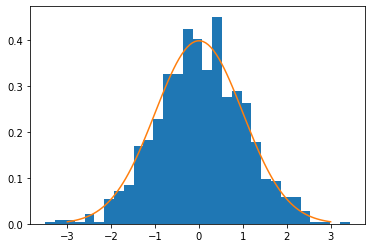

In [ ]:
samples, dist_list = n_dim_dist([stats.norm._pdf, gaussian, normalize_pdf(arb_dist)], 1000) # lambda x:stats.beta.pdf(x, 0.2,2)

plt.hist(samples[1], bins=int(np.sqrt(len(samples[1]))), density=True)
plt.plot(np.linspace(-3, 3, 100), [dist_list[1].pdf(x) for x in np.linspace(-3, 3, 100)])

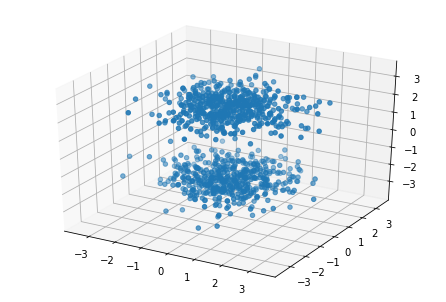

In [ ]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(samples[0], samples[1], samples[2])
plt.show()

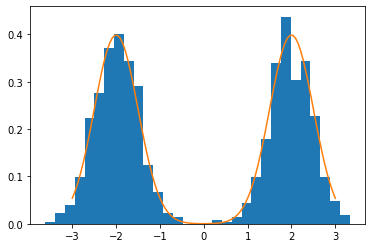

(__main__.RandomDist, __main__.RandomDist)

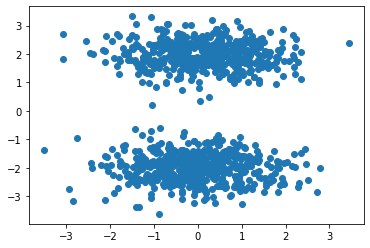

In [ ]:
plt.hist(samples[2], bins=int(np.sqrt(len(samples[1]))), density=True)
plt.plot(np.linspace(-3, 3, 100), [dist_list[2].pdf(x) for x in np.linspace(-3, 3, 100)])
plt.show()

plt.scatter(samples[1], samples[2])

type(dist_list[0]), type(dist_list[1])

write a function that's a linear combination of the sampled data and lets adjust the total level of variance explanation from the sampled data.

In [ ]:
def lin_func(x):
  """X needs to be a 2D array, where the first dim are samples, and the second
  dim are variables. This will map to the formula: y = 0.5*x1 + 4*x2 - 2*x3"""
  return 0.5 * x[0] + 4 * x[1] - 2 * x[2]

def nonlin_func(x):
  """X needs to be a 2D array, where the first dim are samples, and the second
  dim are variables."""
  return 1 * x[0] + 2 * x[0] ** 2 + 3 * x[0] ** 4 + 5 * x[1] ** 2 - 6 * x[2]

def sin_func(x):
  return np.sin(3 * (x[0])) + np.cos(x[1] - 0.2) + np.sin(x[1] * 1.3)


def simulate_outcome(samples, relation, r2 = 1):

  y = relation(samples)
  #err_std = np.sqrt(-(np.std(y)**2)*(r2-1))/np.sqrt(r2)
  # another form, assuming r2 and std(y) are positive
  err_std = np.sqrt(1 / r2 - 1) * np.std(y)

  return y + np.random.randn(len(y)) * err_std


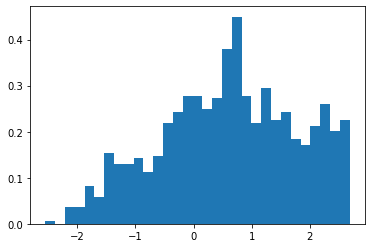

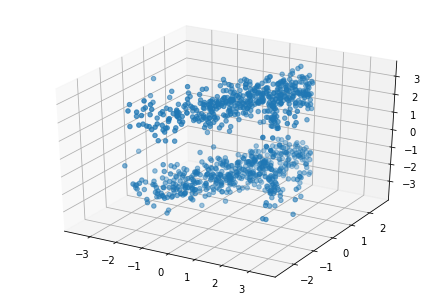

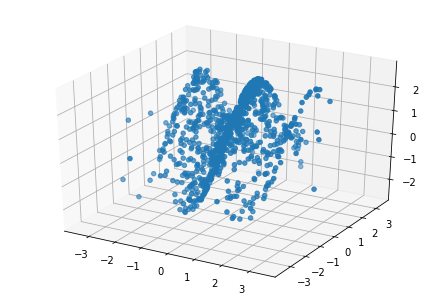

In [ ]:
# define y
y = simulate_outcome(samples, sin_func)

# plot a hist of y
plt.hist(y, bins=int(np.sqrt(len(samples[1]))), density=True)

# plot it 3d
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(samples[1], y, samples[2])
plt.show()

# plot different dimensions of the same data
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(samples[0], samples[1], y)
plt.show()

### Check how they work

In [ ]:
import sklearn.linear_model
samples.T.shape

true_r2 = 0.05
y = simulate_outcome(samples, sin_func, r2=true_r2)
X = samples.T

model = sklearn.linear_model.LinearRegression()
model.fit(X, y)

r2 = model.score(X, y)
print("Variance possibly explainable:\t{0} %\n"
      "Variance explained by model:\t{1} %".format(np.round(true_r2*100, 2),
                                                   np.round(r2*100, 2)))



Variance possibly explainable:	5.0 %
Variance explained by model:	1.92 %


Variance theoretically explainable:	5.0 %
Variance explained by model:		5.32 %


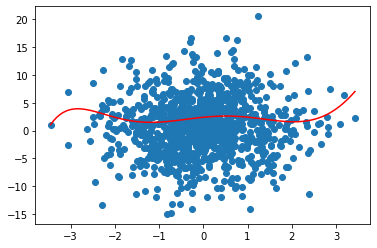

In [ ]:
# do it with a design matrix instead

def polynomial(x, order=0):
  return x ** order

def design_matrix(x, basis_func, max_order, **kwargs):

  return np.vstack([basis_func(x=feature, order=order, **kwargs) for feature in x for order in range(max_order)])

order = 7

X = design_matrix(samples, basis_func=polynomial, max_order=order).T
model = sklearn.linear_model.LinearRegression()
model.fit(X, y)

r2 = model.score(X, y)
print("Variance theoretically explainable:\t{0} %\n"
      "Variance explained by model:\t\t{1} %".format(np.round(true_r2*100, 2),
                                                     np.round(r2*100, 2)))

ax = 0
x_space = np.linspace(np.min(samples[ax]), np.max(samples[ax]), 100)
X_pred = design_matrix(np.array([x_space, np.zeros(100), np.zeros(100)]), basis_func=polynomial, max_order=order).T
plt.scatter(samples[ax], y)
plt.plot(x_space, model.predict(X_pred), "r-")
plt.show()

## Generate Time Series - Arima Processes

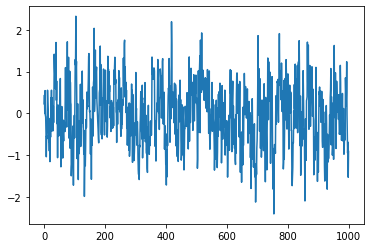

In [ ]:
nsample = 1000
f = np.vstack([arma_generate_sample([1, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.1, 0.1, 0.05],
                                    [1, 0.5, 0.3, 0.1, 0.3, 0.5, 0.3, 0.1, 0.3, 0.5, 0.3, 0.1, 0.3, 0.5, 0.3], nsample, 0.2),
               arma_generate_sample([1], [1, 0.7, 0.6, 0.5, 0.2, 0.3, 0.2, 0.1, 0.05], nsample, 0.8),
               arma_generate_sample([1, 0, 0, 0, 0, 0.2], [1, 0, 0, 0, 0.5, 0, 0, 0.3], nsample, 0.3)])

def relation(x):
  return 0.7 * x[0] + 0.5 * x[1] + 0.9 * x[2] + 0.1 * x[0] ** 2


true_r2 = 1
y = simulate_outcome(f, relation, true_r2)

plt.plot(y)

Generate complex Multivariate Timeseries, based on ARIMA models

(3, 10000)

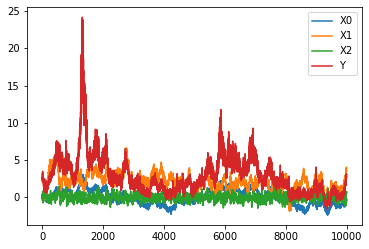

In [ ]:
inSize=3
outSize=1
train_cycles=8000
test_cycles=2000

nsample = train_cycles + test_cycles
ma = np.ones(200)
ma2 = np.linspace(1, 0, 200)
ma3 = np.linspace(1, 0, 30) # np.sin(np.linspace(0,6, 200))
f = np.vstack([arma_generate_sample([1, 0.8, 0.7, 0.6],
                                    ma, nsample, 0.1),
               arma_generate_sample([1, 0.5], ma2, nsample, 0.2),
              arma_generate_sample([1, 0.5], ma3, nsample, 0.2)])

# add some periodicity
f[0] += np.sin(np.linspace(0, 12, nsample))
# add trend
f[1] += np.linspace(3, 1, nsample)

def relation(x):
  return 0.7 * x[0] + 0.5 * x[1] + 0.3 * x[2] + x[2] ** 2  + np.exp(x[0]) 


true_r2 = 1
Y = simulate_outcome(f, relation, true_r2)

x = range(nsample)
plt.plot(x, f[0], x, f[1], x, f[2], x, Y)
plt.legend(["X0", "X1", "X2", "Y"])
f.shape

# optionally: introduce additional time lag
# time_lag = 5
# f = f[:, :-time_lag]
# Y = Y[time_lag :]